# Twitter Sentiment Analysis Using Various Machine Learning Classifiers.

# Importing libraries <a id="1"></a>

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for plotting
import seaborn as sns
from wordcloud import WordCloud

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import BernoulliNB

# Utility
import pandas as pd
import string
import pickle
import warnings
warnings.filterwarnings('ignore')
import re

#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

## Load the Dataset <a id="2"></a>

In [72]:
# load
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])
data = data.sample(frac=1)
data = data[:200000]

## Data Visualization and Exploratory analysis <a id="3"></a>

Details of the dataset

* date
* polarity : the polarity of the tweet (0 = negative 4 = positive)
* user : the user that tweeted 
* text : the text of the tweet 

**Target**: the polarity of the tweet (0 = negative, 4 = positive)


In [73]:
print("Dataset shape:")
print(data.shape)

Dataset shape:
(200000, 6)


In [74]:
data.head(7)

,polarity,id,date,query,user,text
636806,0,2234020756,Thu Jun 18 22:17:23 PDT 2009,NO_QUERY,mrschaddybear,This is turning out to be a surprisingly good ...
1363513,4,2049537195,Fri Jun 05 17:03:17 PDT 2009,NO_QUERY,rzwo,long week; short weekend; starting our move to...
1503421,4,2071967875,Sun Jun 07 20:10:50 PDT 2009,NO_QUERY,AbnerPotter,&quot;Let true love decide if we should be tog...
1117377,4,1973402269,Sat May 30 11:04:43 PDT 2009,NO_QUERY,maggiektvb7,@hccidaho I drink it at work. We have an indus...
809120,4,1469392772,Tue Apr 07 06:14:26 PDT 2009,NO_QUERY,MGzm,I'm a circus act these days. Juggling it all!...
999941,4,1879940181,Thu May 21 23:35:50 PDT 2009,NO_QUERY,Trinity_B,@TheBossDonCJ Lmfaoo. Trey is my love.
492036,0,2184058531,Mon Jun 15 15:21:41 PDT 2009,NO_QUERY,mike868y,Kind of a crappy day at work...one of the weed...


In [75]:
data['polarity'].unique()

# Normalizing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
636806,0,2234020756,Thu Jun 18 22:17:23 PDT 2009,NO_QUERY,mrschaddybear,This is turning out to be a surprisingly good ...
1363513,1,2049537195,Fri Jun 05 17:03:17 PDT 2009,NO_QUERY,rzwo,long week; short weekend; starting our move to...
1503421,1,2071967875,Sun Jun 07 20:10:50 PDT 2009,NO_QUERY,AbnerPotter,&quot;Let true love decide if we should be tog...
1117377,1,1973402269,Sat May 30 11:04:43 PDT 2009,NO_QUERY,maggiektvb7,@hccidaho I drink it at work. We have an indus...
809120,1,1469392772,Tue Apr 07 06:14:26 PDT 2009,NO_QUERY,MGzm,I'm a circus act these days. Juggling it all!...


In [76]:
# Describing the dataset
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.502075,1.998259e+09
std,0.499997,1.934781e+08
min,0.000000,1.467812e+09
25%,0.000000,1.956863e+09
50%,1.000000,2.001858e+09
75%,1.000000,2.176769e+09
max,1.000000,2.329204e+09


In [77]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print(f'Total length of the data is:         {data.shape[0]}')
print(f'No. of positve tagged sentences is:  {len(positives)}')
print(f'No. of negative tagged sentences is: {len(negatives)}')

Total length of the data is:         200000
No. of positve tagged sentences is:  100415
No. of negative tagged sentences is: 99585


In [78]:
def word_count(words):
    return len(words.split())

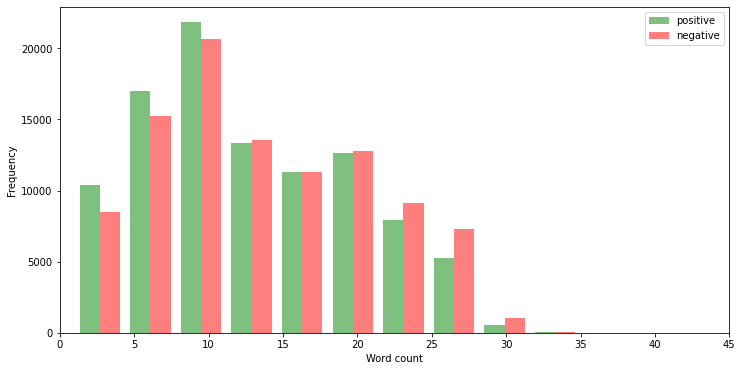

In [79]:
# plot word count distribution for both positive and negative 

data['word count'] = data['text'].apply(word_count)
p = data['word count'][data.polarity == 1]
n = data['word count'][data.polarity == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.ylabel('Frequency')
plt.xlabel('Word count')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [80]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(20)

[('the', 65305),
 ('and', 36817),
 ('you', 29596),
 ('for', 26659),
 ('have', 17967),
 ('that', 16046),
 ("i'm", 15874),
 ('just', 15526),
 ('but', 15311),
 ('with', 14349),
 ('was', 12753),
 ('not', 12695),
 ('this', 11054),
 ('get', 9997),
 ('good', 9562),
 ('like', 9412),
 ('all', 9372),
 ('are', 9343),
 ('out', 8657),
 ('your', 8074)]

# Data Processing <a id="4"></a>

<AxesSubplot:xlabel='polarity', ylabel='count'>

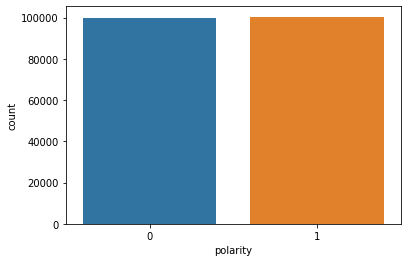

In [81]:
%matplotlib inline
sns.countplot(data['polarity'])

In [82]:
# Removing the unnecessary columns.
data.drop(['date','query','user','word count'], axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)

In [83]:
data.head(10)

,polarity,text
636806,0,This is turning out to be a surprisingly good ...
1363513,1,long week; short weekend; starting our move to...
1503421,1,&quot;Let true love decide if we should be tog...
1117377,1,@hccidaho I drink it at work. We have an indus...
809120,1,I'm a circus act these days. Juggling it all!...
999941,1,@TheBossDonCJ Lmfaoo. Trey is my love.
492036,0,Kind of a crappy day at work...one of the weed...
1516607,1,@lucydurack is following me!!!! well that made...
296463,0,no breathing time anymore
1028846,1,"A smile is the perfect gift. Free, easy, feels..."


In [84]:
# Check for null values
(data.isnull().sum() / len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [85]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

In [86]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
{'as', 've', 'not', 'isn', 'just', "should've", 'yourselves', 'on', 'further', 'ma', 'he', 'weren', 'him', 're', 'mustn', 'by', 'because', 'they', 'herself', 's', 'had', 'again', "doesn't", 'it', 'most', 'no', 'our', 'aren', 'few', 'your', "mightn't", "mustn't", "you're", 'nor', 'wasn', 'then', 'himself', 'more', 'll', 'but', 'how', 'his', 'same', 'shouldn', 'through', "shouldn't", 'she', 'm', 'having', "that'll", "needn't", 'myself', 'themselves', 'of', 'yourself', "wasn't", "hasn't", "couldn't", 'them', 'into', 'my', 'once', "wouldn't", 'am', 'what', 'an', 'up', 'there', "haven't", 'which', 'under', 'very', 'the', 'will', 'that', 'do', 'this', "isn't", 'mightn', 'me', 'is', 'does', 'until', 'for', 'over', "didn't", "won't", 'from', 'its', 'you', 'and', 'down', 'any', 'at', 'haven', 'couldn', 'yours', 'we', 'have', 'didn', 'between', "it's", 'can', 'doesn', 'their', 'ne

In [87]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

> The Preprocessing steps taken are:

* Lower Casing: Each text is converted to lowercase.
* Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".

* Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")
* Removing Short Words: Words with length less than 2 are removed.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

In [88]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
    tweet = tweet.lower()
    tweet=tweet[1:]
    tokens = word_tokenize(tweet)
    final_tokens = [w for w in tokens if w not in stopword]
    wordLemm = WordNetLemmatizer()
    tweet = re.sub(urlPattern,'',tweet)
    tweet = re.sub(userPattern,'', tweet) 
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [89]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [90]:
data.head(10)

,polarity,text,processed_tweets
636806,0,This is turning out to be a surprisingly good ...,turning surprisingly good day wish chaddy n't ...
1363513,1,long week; short weekend; starting our move to...,ong week short weekend starting move new place
1503421,1,&quot;Let true love decide if we should be tog...,quot let true love decide together quot bonita...
1117377,1,@hccidaho I drink it at work. We have an indus...,hccidaho drink work industrial coffee maker we...
809120,1,I'm a circus act these days. Juggling it all!...,'m circus act day juggling beat nothing juggle
999941,1,@TheBossDonCJ Lmfaoo. Trey is my love.,thebossdoncj lmfaoo trey love
492036,0,Kind of a crappy day at work...one of the weed...,ind crappy day work ... one weedwackers ran ga...
1516607,1,@lucydurack is following me!!!! well that made...,lucydurack following well made day
296463,0,no breathing time anymore,breathing time anymore
1028846,1,"A smile is the perfect gift. Free, easy, feels...",smile perfect gift free easy feel good


# Analyzing the data <a id="5"></a>

### Word-Cloud for Negative tweets.

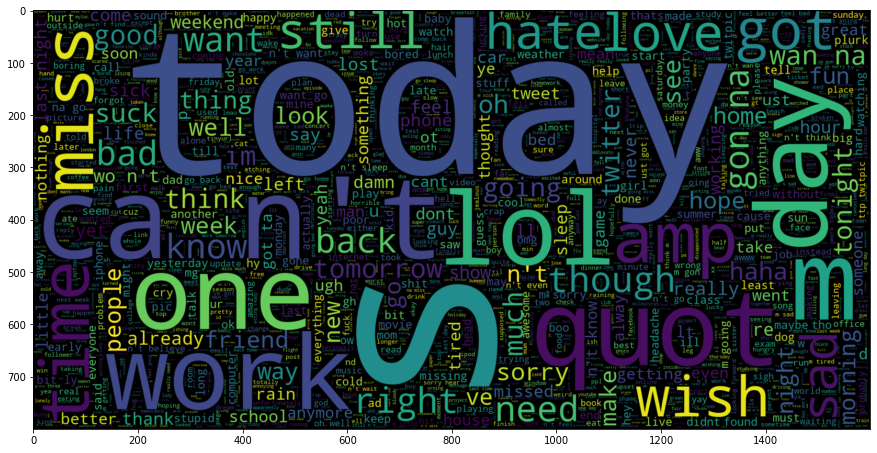

In [91]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

### Word-Cloud for Positive tweets.

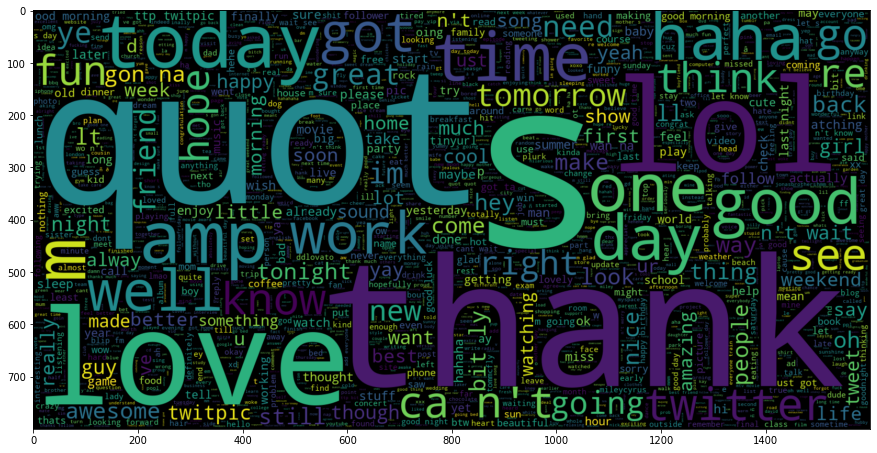

In [92]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

## Vectorization and Splitting the data <a id="6"></a>
Storing input variable-processes_tweets to X and output variable-polarity to y

In [93]:
X = data['processed_tweets'].values
y = data['polarity'].values

In [94]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


### Convert text to word frequency vectors

In [95]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))

Vector fitted.
No. of feature_words:  160544


In [96]:
print(X.shape)
print(y.shape)

(200000, 160544)
(200000,)


## Split train and test

The Preprocessed Data is divided into 2 sets of data:

* Training Data: The dataset upon which the model would be trained on. Contains 80% data.
* Test Data: The dataset upon which the model would be tested against. Contains 20% data.




In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [98]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 160544)
y_train (160000,)

X_test (40000, 160544)
y_test (40000,)


# Model Building <a id="7"></a>

### Model evaluating function

In [99]:
from sklearn.model_selection import cross_val_score
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    crossval_scores = cross_val_score(model, X_test, y_test, cv=2)
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print()
    print('Mean Accuracy on testing data using 5 fold cross validation: {} %'.format(crossval_scores.mean()*100))
    print('Standard Deviation using 5 fold cross validation: {}'.format(crossval_scores.std()*100))    
    print()
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Logistic Regression <a id="8"></a>

Accuracy of model on training data : 83.238125

Mean Accuracy on testing data using 5 fold cross validation: 74.055 %
Standard Deviation using 5 fold cross validation: 0.025000000000002798

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     19945
           1       0.76      0.80      0.78     20055

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



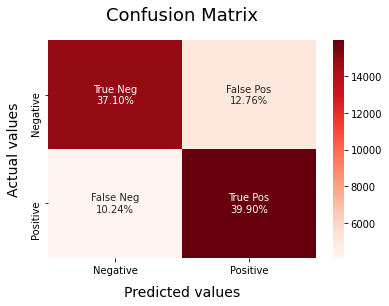

In [100]:
lg = LogisticRegression()
history=lg.fit(X_train, y_train)
model_Evaluate(lg)

### Linear SVM <a id="9"></a>

Accuracy of model on training data : 92.545625

Mean Accuracy on testing data using 5 fold cross validation: 73.0925 %
Standard Deviation using 5 fold cross validation: 0.06250000000000422

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     19945
           1       0.75      0.78      0.76     20055

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



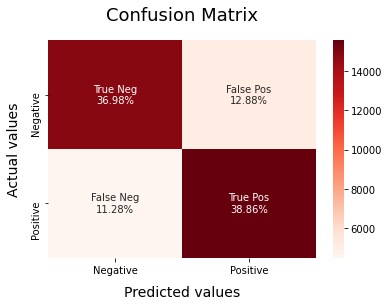

In [101]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_Evaluate(svm)

### Random Forest <a id="10"></a>

Accuracy of model on training data : 75.661875

Mean Accuracy on testing data using 5 fold cross validation: 67.78500000000001 %
Standard Deviation using 5 fold cross validation: 0.6400000000000017

              precision    recall  f1-score   support

           0       0.75      0.63      0.68     19945
           1       0.68      0.79      0.73     20055

    accuracy                           0.71     40000
   macro avg       0.71      0.71      0.71     40000
weighted avg       0.71      0.71      0.71     40000



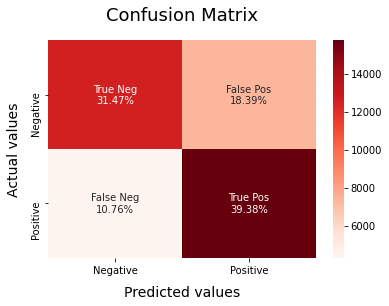

In [102]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

### Naive Bayes <a id="11"></a>

Accuracy of model on training data : 85.995

Mean Accuracy on testing data using 5 fold cross validation: 73.32000000000001 %
Standard Deviation using 5 fold cross validation: 0.22500000000000298

              precision    recall  f1-score   support

           0       0.74      0.79      0.76     19945
           1       0.77      0.73      0.75     20055

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



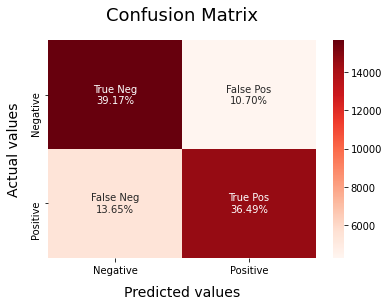

In [103]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)